In [1]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

sagemaker-us-east-1-011113936377


In [2]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [3]:
import sys
import re
import os
import json
import datetime
import pytz
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t) and t.upper() not in allsymbols]


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
  allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)

wnl = WordNetLemmatizer()


In [6]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [7]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [8]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



Progress: [####################] 99.9%


In [9]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
  fh.write("\n".join(foundsymbols))
foundsymbols

3661


['TSLA',
 'B',
 'AMZN',
 'COST',
 'C',
 'LULU',
 'AMD',
 'FB',
 'PTON',
 'AAPL',
 'GOLD',
 'ROKU',
 'NFLX',
 'DIS',
 'HAS',
 'GOOD',
 'ONCY',
 'SPCE',
 'AMC',
 'KR',
 'PM',
 'ABC',
 'X',
 'Y',
 'CYBR',
 'PANW',
 'RPD',
 'EDIT',
 'DTE',
 'DCOM',
 'AT',
 'ACB',
 'THC',
 'MU',
 'IP',
 'AG',
 'GILD',
 'TJX',
 'HTZ',
 'TVTY',
 'DGX',
 'QQQ',
 'TA',
 'BYND',
 'POST',
 'SR',
 'NIO',
 'RING',
 'A',
 'NEW',
 'IT',
 'FOSL',
 'BK',
 'PINS',
 'KRTX',
 'OVID',
 'DOW',
 'SBUX',
 'VC',
 'MCD',
 'MSFT',
 'WMT',
 'SNAP',
 'PECK',
 'HUGE',
 'GDP',
 'WELL',
 'CDC',
 'BA',
 'V',
 'FAT',
 'NOC',
 'LMT',
 'RH',
 'AAL',
 'GO',
 'SDC',
 'ALGN',
 'ONE',
 'ATVI',
 'M',
 'CEO',
 'K',
 'ALLY',
 'SIX',
 'CME',
 'AM',
 'LIVE',
 'FIT',
 'SWBI',
 'EC',
 'F',
 'CRM',
 'BAC',
 'CTO',
 'PEP',
 'UAL',
 'DAL',
 'JNJ',
 'PCG',
 'E',
 'PLUS',
 'AMTD',
 'TTD',
 'DEA',
 'CBD',
 'CCL',
 'ARE',
 'OUT',
 'G',
 'BMO',
 'IONS',
 'FOR',
 'HAL',
 'INFY',
 'KO',
 'SYF',
 'NDAQ',
 'NEE',
 'ERIC',
 'DPZ',
 'LUV',
 'UNP',
 'AXP',
 'SNY'

In [10]:
#split into multiple corpus here


import random
random.shuffle(relevant_posts)
n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

34504 27603


In [11]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

27603 13801
6901
3450


3451

In [12]:
vocab_input[0]

'Shit EA DD: Apex legends has a cheater/hacker problem on PC and it’s costing them player base. Also, Anthem patches still aren’t satisfying their already measly playerbase. Reading through the Apex subreddit and they’re having problems with 1. hackers; 2. Enemy teams working together (discord? Idfk); 3. EA not yet moving to fix the problem.\n\nAs a gamer, there is nothing worse Than cheaters. And their competitors PubG and Fortnite are ontop of these issues. \n\nSome Internet cafe owner specifically commented about seeing regular Apex players (customers) going back to PubG, Fortnite and even Csgo. (They Track what games players play and more of them are play a couple Apex games then moving to their old favourites mid session).\n\nWhat does this mean for the stock? Idk. Just pointing out that EA’s two big early hopefuls for 2019 are having some troubles'

In [13]:
vocab_size=5000

vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english', tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)

vectors = vectorizer.fit_transform(vocab_input)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 5000


In [14]:
vocab_list

['abbott',
 'abbvie',
 'ability',
 'able',
 'aboard',
 'absolute',
 'absolutely',
 'absurd',
 'abuse',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',
 'accept',
 'accepted',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'according',
 'accordingly',
 'account',
 'accountant',
 'accounted',
 'accounting',
 'accurate',
 'achieve',
 'achieved',
 'acquire',
 'acquired',
 'acquires',
 'acquiring',
 'acquisition',
 'acting',
 'action',
 'active',
 'actively',
 'activision',
 'activist',
 'activity',
 'actual',
 'actually',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'adderall',
 'addict',
 'addicted',
 'addiction',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adj',
 'adjust',
 'adjusted',
 'adjustment',
 'administration',
 'admit',
 'adoption',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'adverse',
 'advertisement',
 'advertiser',
 'advertising',
 'advice',
 'advise',
 'advised',
 'adviser',
 'advisor',
 'advisory',
 'aerospace',
 'a

In [15]:
threshhold=.05
lt = LemmaTokenizer()
from scipy.sparse import csr_matrix

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"]
    texttokens=lt(text)
    #print(text,texttokens)
    #print("Symbol:",thesesymbols)
    wordvector=[]
    for word in vocab_list:
        wordvector.append(texttokens.count(word))
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
        #if True:
            
                #if word in texttokens:
                    #print(word)
                #    wordvector.append(1)
                #else:
                #    wordvector.append(0)
                #locword = text.find(word)
                #distance=0
                #if locword>-1:
                #    distance=abs(text.find(symbolmap[symbol])-locword)
                #    print(symbol,word,distance)
                #wordvector.append(distance)
            #print(symbol,wordvector)
            posttime=[0,0,0,0]
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=21:
                posttime[0]=1
            elif start.hour < 5:
                posttime[0]=1
            elif start.hour < 9:
                posttime[1]=1
            elif start.hour < 16:
                posttime[2]=1
            else:
                posttime[3]=1
            if start.hour>=9:
              start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
                #print(symbol,delta,result,wordvector)
            else:
                result=0
            returnarray.append([result]+posttime+wordvector)
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray



training_vector = []
i=0
for posts in training_posts:
    #try:
    if True:
       response=calculateData(posts)
       for row in response:
            training_vector.append(row)
    #except Exception as err:
    #    print("Error",err)
    #    pass
    i+=1
    if(round(i/100,0)==i/100):
        update_progress(i / len(training_posts))
        print(len(training_posts))



Progress: [####################] 100.0%
27603


In [16]:
import pandas as pd
pd.DataFrame(training_vector, columns=["Output"]+["21-4","5-8","9-15","16-20"]+vocab_list)

,Output,21-4,5-8,9-15,16-20,abbott,abbvie,ability,able,aboard,...,yr/yr,ytd,yuan,zacks,zealand,zero,zillow,zombie,zone,zoom
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69689,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69690,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69691,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69692,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
import boto3
import sagemaker.amazon.common as smac
import io

np_training_vector = np.array(training_vector).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np_training_vector[:,1:], np_training_vector[:,0])
buf.seek(0)

prefix = 'wsb-training'
key= 'wsb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))


output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))





uploaded training data location: s3://sagemaker-us-east-1-011113936377/wsb-training/train/wsb-data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-011113936377/wsb-training/output


In [21]:


from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

role = get_execution_role()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.10xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=len(vocab_list)+4,
                           predictor_type='multiclass_classifier',
                           num_classes=3,
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-11 18:09:26 Starting - Starting the training job...
2020-08-11 18:09:29 Starting - Launching requested ML instances......
2020-08-11 18:10:46 Starting - Preparing the instances for training......
2020-08-11 18:11:37 Downloading - Downloading input data......
2020-08-11 18:12:57 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/11/2020 18:13:02 INFO 140207298684736] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in

[2020-08-11 18:13:31.417] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 13636, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 4.656249094119017, "sum": 4.656249094119017, "min": 4.656249094119017}}, "EndTime": 1597169611.4173, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1597169611.417203}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.158718731321137, "sum": 6.158718731321137, "min": 6.158718731321137}}, "EndTime": 1597169611.417387, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1597169611.417371}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.490535543156767, "sum": 12.490535543156767, "min": 12.49053554

[2020-08-11 18:13:45.244] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 13814, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 3.8194895062501404, "sum": 3.8194895062501404, "min": 3.8194895062501404}}, "EndTime": 1597169625.244107, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1597169625.244038}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.072112373264357, "sum": 6.072112373264357, "min": 6.072112373264357}}, "EndTime": 1597169625.244177, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1597169625.244163}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.514600016276042, "sum": 12.514600016276042, "min": 12.514

[2020-08-11 18:13:59.016] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 13758, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 3.344708563925206, "sum": 3.344708563925206, "min": 3.344708563925206}}, "EndTime": 1597169639.016284, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1597169639.016214}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.117992622112406, "sum": 6.117992622112406, "min": 6.117992622112406}}, "EndTime": 1597169639.016356, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1597169639.016342}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.574103286567775, "sum": 12.574103286567775, "min": 12.574103

[2020-08-11 18:14:13.592] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 14565, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.996029139113152, "sum": 2.996029139113152, "min": 2.996029139113152}}, "EndTime": 1597169653.592861, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1597169653.592791}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.62563870221719, "sum": 5.62563870221719, "min": 5.62563870221719}}, "EndTime": 1597169653.592936, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1597169653.592922}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.161930253478303, "sum": 12.161930253478303, "min": 12.16193025

[2020-08-11 18:14:28.107] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 14503, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.78443307438116, "sum": 2.78443307438116, "min": 2.78443307438116}}, "EndTime": 1597169668.107703, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1597169668.107609}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.727718232691973, "sum": 5.727718232691973, "min": 5.727718232691973}}, "EndTime": 1597169668.107792, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1597169668.107776}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 11.244609671406362, "sum": 11.244609671406362, "min": 11.24460967

[2020-08-11 18:14:42.399] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 14278, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.6692189657277074, "sum": 2.6692189657277074, "min": 2.6692189657277074}}, "EndTime": 1597169682.399684, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1597169682.399588}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.657014433323652, "sum": 5.657014433323652, "min": 5.657014433323652}}, "EndTime": 1597169682.399773, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1597169682.399756}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.244307449165431, "sum": 12.244307449165431, "min": 12.24

[2020-08-11 18:14:56.588] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 14175, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.603138311320338, "sum": 2.603138311320338, "min": 2.603138311320338}}, "EndTime": 1597169696.588513, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1597169696.588419}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.456727005092577, "sum": 5.456727005092577, "min": 5.456727005092577}}, "EndTime": 1597169696.5886, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1597169696.588584}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 12.145909835113876, "sum": 12.145909835113876, "min": 12.1459098

[2020-08-11 18:15:11.122] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 14518, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5721777935685783, "sum": 2.5721777935685783, "min": 2.5721777935685783}}, "EndTime": 1597169711.122588, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1597169711.122493}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.769181828115178, "sum": 5.769181828115178, "min": 5.769181828115178}}, "EndTime": 1597169711.122676, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1597169711.12266}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.531233924778029, "sum": 10.531233924778029, "min": 10.531

[2020-08-11 18:15:26.433] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 15296, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5576077068811176, "sum": 2.5576077068811176, "min": 2.5576077068811176}}, "EndTime": 1597169726.433797, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1597169726.433728}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.035818147330448, "sum": 6.035818147330448, "min": 6.035818147330448}}, "EndTime": 1597169726.433869, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1597169726.433856}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.12

[2020-08-11 18:15:41.625] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 15180, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5506116845141884, "sum": 2.5506116845141884, "min": 2.5506116845141884}}, "EndTime": 1597169741.625821, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1597169741.625727}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.522290238566782, "sum": 5.522290238566782, "min": 5.522290238566782}}, "EndTime": 1597169741.625914, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1597169741.625898}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.

[2020-08-11 18:15:56.698] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 15061, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5471319860699535, "sum": 2.5471319860699535, "min": 2.5471319860699535}}, "EndTime": 1597169756.699003, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1597169756.698898}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.055820131411497, "sum": 5.055820131411497, "min": 5.055820131411497}}, "EndTime": 1597169756.699095, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1597169756.699075}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.

[2020-08-11 18:16:11.813] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 15103, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.544281030194513, "sum": 2.544281030194513, "min": 2.544281030194513}}, "EndTime": 1597169771.814022, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1597169771.813928}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.241558363903528, "sum": 5.241558363903528, "min": 5.241558363903528}}, "EndTime": 1597169771.814109, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1597169771.814093}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.129

[2020-08-11 18:16:26.930] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 15105, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5411827780186447, "sum": 2.5411827780186447, "min": 2.5411827780186447}}, "EndTime": 1597169786.931043, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1597169786.930949}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.488314972362299, "sum": 5.488314972362299, "min": 5.488314972362299}}, "EndTime": 1597169786.931116, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1597169786.931103}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.

[2020-08-11 18:16:42.038] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 15096, "num_examples": 349, "num_bytes": 1398619192}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.538026535648039, "sum": 2.538026535648039, "min": 2.538026535648039}}, "EndTime": 1597169802.038632, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1597169802.038562}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.042291378152782, "sum": 6.042291378152782, "min": 6.042291378152782}}, "EndTime": 1597169802.038701, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1597169802.038688}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 10.129058273140041, "sum": 10.129058273140041, "min": 10.129


2020-08-11 18:16:52 Uploading - Uploading generated training model
2020-08-11 18:16:52 Completed - Training job completed
Training seconds: 315
Billable seconds: 315


In [22]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.10xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [23]:
test_vector = []
i=0
for posts in test_posts:
    #try:
    if True:
       response=calculateData(posts)
       for row in response:
            test_vector.append(row)
    #except Exception as err:
    #    print("Error",err)
    #    pass
    i+=1
    if True:
        update_progress(i / len(test_posts))
        print(len(test_posts))
np_test_vector = np.array(test_vector).astype('float32')

Progress: [####################] 100.0%
3451


In [24]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [25]:
np_test_vector[:4,1:]

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
result = linear_predictor.predict(np_training_vector[:4,1:])
print(result)

{'predictions': [{'score': [0.6194989681243896, 0.16627904772758484, 0.2142219990491867], 'predicted_label': 0}, {'score': [0.6194989681243896, 0.16627904772758484, 0.2142219990491867], 'predicted_label': 0}, {'score': [0.5405163764953613, 0.26459643244743347, 0.19488713145256042], 'predicted_label': 0}, {'score': [0.5506197810173035, 0.267273873090744, 0.18210631608963013], 'predicted_label': 0}]}


In [27]:
import numpy as np

predictions = []
for array in np.array_split(np_test_vector[:,1:], 100):
    #print(array)
    result = linear_predictor.predict(array)
    #print(result)
    predictions += [r['predicted_label'] for r in result['predictions']]
#print(predictions)
predictions = np.array(predictions)


In [28]:
test_labels=[]
for value in np_test_vector[:,0]:
    #print(value[0])
    test_labels.append(value)
print(len(test_labels),len(predictions))

8009 8009


In [29]:
import pandas as pd

pd.crosstab([test_labels], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0,1,2
actuals,,,
0.0,4035,201,87
1.0,1860,155,54
2.0,1461,74,82


In [30]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([3,3], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

Test error: 46.7%


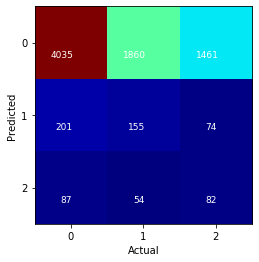

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(predictions), numpy.asarray(test_labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [34]:
import sklearn

In [35]:

sklearn.metrics.f1_score(numpy.asarray(test_labels),numpy.asarray(predictions),average=None)

array([0.69098382, 0.12404962, 0.08913043])

In [36]:
sklearn.metrics.recall_score(numpy.asarray(test_labels),numpy.asarray(predictions),average=None)

array([0.9333796 , 0.07491542, 0.05071119])

In [37]:
sklearn.metrics.precision_score(numpy.asarray(test_labels),numpy.asarray(predictions),average=None)

array([0.54853181, 0.36046512, 0.367713  ])

In [38]:
print(sklearn.metrics.classification_report(numpy.asarray(test_labels),numpy.asarray(predictions)))

              precision    recall  f1-score   support

         0.0       0.55      0.93      0.69      4323
         1.0       0.36      0.07      0.12      2069
         2.0       0.37      0.05      0.09      1617

    accuracy                           0.53      8009
   macro avg       0.43      0.35      0.30      8009
weighted avg       0.46      0.53      0.42      8009



In [39]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

In [40]:
import numpy

In [42]:
filter_arr = numpy.asarray(predictions) == numpy.asarray(test_labels)
newarr = numpy.asarray(predictions)[filter_arr]
bearbear = np.count_nonzero(newarr == 1)
bullbull = np.count_nonzero(newarr == 2)
bullbear=numpy.count_nonzero((numpy.asarray(predictions) == 2) & (numpy.asarray(test_labels) == 1))
bearbull=numpy.count_nonzero((numpy.asarray(predictions) == 1) & (numpy.asarray(test_labels) == 2))
print("Bull Rating:",bullbull/(bullbull+bullbear))
print("Bear Rating:",bearbear/(bearbear+bearbull))

Bull Rating: 0.6029411764705882
Bear Rating: 0.6768558951965066
